In [1]:
#Importing libraries and setting seed
seed = 45871
import pandas as pd
import numpy as np
import math
import statistics
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model

# Load data + compute new columns

In [2]:
#Loading the data file
file_path = 'test data_ascending.xlsx'
df = pd.read_excel(file_path)

# Calculating log returns
df['Log_Returns'] = (np.log(df['Last Price']) - np.log(df['Last Price'].shift(1)))*100

# Calculate volatility on log returns 
window_size = 2  
df['std_dev'] = df['Log_Returns'].rolling(window=window_size).std()

df = df.dropna().reset_index(drop=True)

# Display data frame
print(df.head())
print(df.tail())

        Date  Last Price  Log_Returns   std_dev
0 2005-04-26       17.15    -1.734148  3.700323
1 2005-04-27       16.35    -4.777028  2.151641
2 2005-04-28       15.95    -2.476907  1.626431
3 2005-04-29       16.40     2.782251  3.718786
4 2005-05-03       16.10    -1.846206  3.272813
           Date  Last Price  Log_Returns   std_dev
4871 2024-03-25       63.74     5.465136  0.982766
4872 2024-03-26       61.06    -4.295532  6.901835
4873 2024-03-27       61.21     0.245359  3.210895
4874 2024-03-28       60.58    -1.034577  0.905051
4875 2024-04-01       60.58     0.000000  0.731556


# Split data frame

In [3]:
start_date = '2008-04-03'
df = df[df['Date'] >= start_date]

In [4]:
# Split data frame into training data and test data
test_size = int(len(df) * 0.2)  
df_train = df[:-test_size]
df_test = df[-test_size:]

# Exclude NaN values from the date frames 
df_train = df_train.dropna()
df_test = df_test.dropna()


# Train model + predict observations

In [5]:
def rolling_window_variance(df, window_size):
    # Shift the log returns by one day to exclude the current day's return from the calculation
    shifted_log_returns = df['Log_Returns'].shift(1)

    # Calculate the rolling mean for the shifted log returns
    df['rolling_mean'] = shifted_log_returns.rolling(window=window_size).mean()

    # Function to calculate variance for each window
    def variance_calc(x):
        x = pd.Series(x)
        if len(x.dropna()) == window_size:
            mean = x.mean()
            return ((x - mean) ** 2).sum() / (window_size - 1)
        else:
            return np.nan

    # Apply the variance calculation function on the shifted rolling window
    df['rolling_variance'] = shifted_log_returns.rolling(window=window_size).apply(variance_calc, raw=True)

    # Calculate the rolling standard deviation
    df['predictions'] = np.sqrt(df['rolling_variance'])

    return df


# Setting the window size
window_size = 5  
# Apply the function to dataframe
df = rolling_window_variance(df, window_size)
df_test['predictions'] = df.predictions

print(df[3290:3300])
print(df_test.head())

           Date  Last Price  Log_Returns   std_dev  rolling_mean  \
4043 2021-01-11       34.43    -1.126366  1.122129      1.323729   
4044 2021-01-12       34.56     0.376867  1.062946      0.499953   
4045 2021-01-13       33.55    -2.966008  2.363769      1.002731   
4046 2021-01-14       33.43    -0.358316  1.843917      0.011926   
4047 2021-01-15       31.65    -5.471555  3.615606     -0.722652   
4048 2021-01-18       31.54    -0.348157  3.622790     -1.909076   
4049 2021-01-19       33.00     4.525098  3.445911     -1.753434   
4050 2021-01-20       32.82    -0.546948  3.586478     -0.923788   
4051 2021-01-21       34.03     3.620440  2.946788     -0.439976   
4052 2021-01-22       34.17     0.410558  2.269730      0.355776   

      rolling_variance  predictions  
4043          4.977866     2.231113  
4044          4.934135     2.221291  
4045          2.883526     1.698095  
4046          5.351433     2.313316  
4047          1.984329     1.408662  
4048          5.512847 

# Plot forecast results 

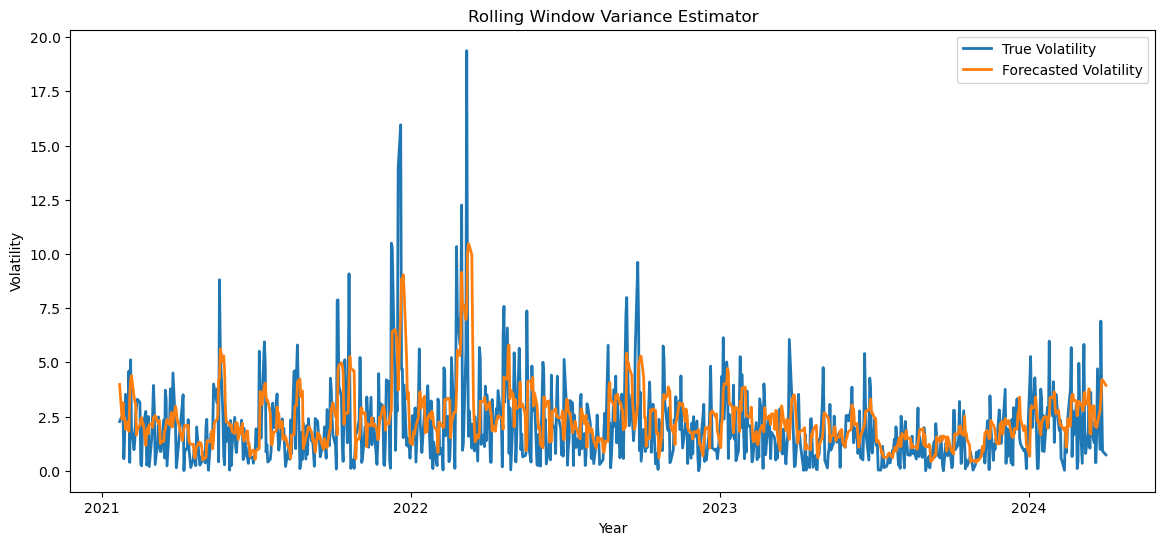

In [6]:
fig, ax = plt.subplots(figsize=(14, 6))

# Plot 'std_dev' and 'predictions'
ax.plot(df.Date[-test_size:], df.std_dev[-test_size:], label='True Volatility', linewidth=2)
ax.plot(df_test['Date'], df_test['predictions'], label='Forecasted Volatility', linewidth=2)

# Set the x-axis to show each year
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# More layout 
plt.title('Rolling Window Variance Estimator')
plt.xlabel('Year')
plt.ylabel('Volatility')
plt.legend()
plt.show()

plt.rcParams.update({'font.size': 20})

# Model evaluation 

In [7]:
# import sklearn.metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [8]:
# oos r^2 for entire test_size
r_squared = r2_score(df_test['std_dev'], df_test['predictions'])
print("R-squared (R^2):", r_squared)

R-squared (R^2): -0.002727544700365625
           Date  Last Price  Log_Returns   std_dev  predictions
4052 2021-01-22       34.17     0.410558  2.269730     3.978363
4053 2021-01-25       33.10    -3.181478  2.539953     2.368273
4054 2021-01-26       33.29     0.572377  2.654377     3.142942
4055 2021-01-27       33.22    -0.210495  0.553574     2.442929
4056 2021-01-28       33.89     1.996788  1.560785     2.422621


In [9]:
# Horizon 1
df_test1 = df_test[:1]

# mse
mse1 = mean_squared_error(df_test1['std_dev'], df_test1['predictions'])
print('MSE_1', mse1)

# mae 
mae1 = mean_absolute_error(df_test1['std_dev'], df_test1['predictions'])
print('MAE_1', mae1)

# median absolute error
squared_errors1 = (df_test1['std_dev']-df_test1['predictions'])**2
median_squared_errors1 = np.median(squared_errors1)
print('MedSE_1', median_squared_errors1)

MSE_1 2.9194288283485545
MAE_1 1.7086336144266139
MedSE_1 2.9194288283485545


In [24]:
# Horizon 5 
df_test5 = df_test[:5]

# mse
mse5 = mean_squared_error(df_test5['std_dev'], df_test5['predictions'])
print('MSE_5', mse5)

# mae 
mae5 = mean_absolute_error(df_test5['std_dev'], df_test5['predictions'])
print('MAE_5', mae5)

# median absolute error
squared_errors5 = (df_test5['std_dev'] - df_test5['predictions'])**2
median_squared_errors5 = np.median(squared_errors5)
print('MedSE_5', median_squared_errors5)

MSE_5 1.5000048868726736
MAE_5 1.0240142129526295
MedSE_5 0.7427622281525924
           Date  Last Price  Log_Returns   std_dev  predictions
4052 2021-01-22       34.17     0.410558  2.269730     3.978363
4053 2021-01-25       33.10    -3.181478  2.539953     2.368273
4054 2021-01-26       33.29     0.572377  2.654377     3.142942
4055 2021-01-27       33.22    -0.210495  0.553574     2.442929
4056 2021-01-28       33.89     1.996788  1.560785     2.422621


In [25]:
# Horizon 10 
df_test10 = df_test[:10]

# mse
mse10 = mean_squared_error(df_test10['std_dev'], df_test10['predictions'])
print('MSE_10', mse10)

# mae 
mae10 = mean_absolute_error(df_test10['std_dev'], df_test10['predictions'])
print('MAE_10', mae10)

# median absolute error
squared_errors10 = (df_test10['std_dev'] - df_test10['predictions'])**2
median_squared_errors10 = np.median(squared_errors10)
print('MedSE_10', median_squared_errors10)

MSE_10 2.81920899057368
MAE_10 1.3820553725514526
MedSE_10 1.7283107071749786
           Date  Last Price  Log_Returns   std_dev  predictions
4052 2021-01-22       34.17     0.410558  2.269730     3.978363
4053 2021-01-25       33.10    -3.181478  2.539953     2.368273
4054 2021-01-26       33.29     0.572377  2.654377     3.142942
4055 2021-01-27       33.22    -0.210495  0.553574     2.442929
4056 2021-01-28       33.89     1.996788  1.560785     2.422621
4057 2021-01-29       32.89    -2.995133  3.529821     1.911508
4058 2021-02-01       32.81    -0.243531  1.945676     2.265854
4059 2021-02-02       34.93     6.261271  4.599590     1.818951
4060 2021-02-03       37.39     6.805723  0.384986     3.451087
4061 2021-02-04       37.23    -0.428840  5.115609     4.200357


In [12]:
# Horizon 15 
df_test15 = df_test[:15]

# mse
mse15 = mean_squared_error(df_test15['std_dev'], df_test15['predictions'])
print('MSE_15', mse15)

# mae 
mae15 = mean_absolute_error(df_test15['std_dev'], df_test15['predictions'])
print('MAE_15', mae15)

# median absolute error
squared_errors15 = (df_test15['std_dev'] - df_test15['predictions'])**2
median_squared_errors15 = np.median(squared_errors15)
print('MedSE_15', median_squared_errors15)

MSE_15 3.0105532239818236
MAE_15 1.4857309096374516
MedSE_15 2.6189353394258124


In [13]:
# Horizon 20 
df_test20 = df_test[:20]

# mse
mse20 = mean_squared_error(df_test20['std_dev'], df_test20['predictions'])
print('MSE_20', mse20)

# mae 
mae20 = mean_absolute_error(df_test20['std_dev'], df_test20['predictions'])
print('MAE_20', mae20)

# median absolute error
squared_errors20 = (df_test20['std_dev'] - df_test20['predictions'])**2
median_squared_errors20 = np.median(squared_errors20)
print('MedSE_20', median_squared_errors20)

MSE_20 2.8632928439310494
MAE_20 1.4639734574613308
MedSE_20 2.2675721319569337


In [14]:
# Horizon 25 
df_test25 = df_test[:25]

# mse
mse25 = mean_squared_error(df_test25['std_dev'], df_test25['predictions'])
print('MSE_25', mse25)

# mae 
mae25 = mean_absolute_error(df_test25['std_dev'], df_test25['predictions'])
print('MAE_25', mae25)

# median absolute error
squared_errors25 = (df_test25['std_dev'] - df_test25['predictions'])**2
median_squared_errors25 = np.median(squared_errors25)
print('MedSE_25', median_squared_errors25)

MSE_25 2.596269204728649
MAE_25 1.3878766562253753
MedSE_25 2.14417991906782


In [15]:
# Horizon 30 
df_test30 = df_test[:30]

# mse
mse30 = mean_squared_error(df_test30['std_dev'], df_test30['predictions'])
print('MSE_30', mse30)

# mae 
mae30 = mean_absolute_error(df_test30['std_dev'], df_test30['predictions'])
print('MAE_30', mae30)

# median absolute error
squared_errors30 = (df_test30['std_dev'] - df_test30['predictions'])**2
median_squared_errors30 = np.median(squared_errors30)
print('MedSE_30', median_squared_errors30)

MSE_30 2.396183672436683
MAE_30 1.3284919767435868
MedSE_30 2.0301944217779377


In [16]:
# Horizon 252 
df_test252 = df_test[:252]

# mse
mse252 = mean_squared_error(df_test252['std_dev'], df_test252['predictions'])
print('MSE_252', mse252)

# mae 
mae252 = mean_absolute_error(df_test252['std_dev'], df_test252['predictions'])
print('MAE_252', mae252)

# median absolute error
squared_errors252 = (df_test252['std_dev'] - df_test252['predictions'])**2
median_squared_errors252 = np.median(squared_errors252)
print('MedSE_252', median_squared_errors252)

MSE_252 4.447939004775011
MAE_252 1.5015437154626698
MedSE_252 1.1668123281879055


In [17]:
# Horizon 2021
start_date2021 = '2021-01-22'
end_date2021 = '2021-12-31'

df_test2021 = df_test[(df_test['Date'] >= start_date2021) & (df_test['Date'] <= end_date2021)]

# mse
mse2021 = mean_squared_error(df_test2021['std_dev'], df_test2021['predictions'])
print('MSE_2021', mse2021)

# mae 
mae2021 = mean_absolute_error(df_test2021['std_dev'], df_test2021['predictions'])
print('MAE_2021', mae2021)

# median absolute error
squared_errors2021 = (df_test2021['std_dev'] - df_test2021['predictions'])**2
median_squared_errors2021 = np.median(squared_errors2021)
print('MedSE_2021', median_squared_errors2021)

MSE_2021 4.540281367681698
MAE_2021 1.5134082402013052
MedSE_2021 1.1668123281879055


In [18]:
# Horizon 2022
start_date2022 = '2022-01-01'
end_date2022 = '2022-12-31'

df_test2022 = df_test[(df_test['Date'] >= start_date2022) & (df_test['Date'] <= end_date2022)]

# mse
mse2022 = mean_squared_error(df_test2022['std_dev'], df_test2022['predictions'])
print('MSE_2022', mse2022)

# mae 
mae2022 = mean_absolute_error(df_test2022['std_dev'], df_test2022['predictions'])
print('MAE_2022', mae2022)

# median absolute error
squared_errors2022 = (df_test2022['std_dev'] - df_test2022['predictions'])**2
median_squared_errors2022 = np.median(squared_errors2022)
print('MedSE_2022', median_squared_errors2022)

MSE_2022 5.268270628027046
MAE_2022 1.6665530445913344
MedSE_2022 1.8252789649871513


In [19]:
# Horizon 2023
start_date2023 = '2023-01-01'
end_date2023 = '2023-12-31'

df_test2023 = df_test[(df_test['Date'] >= start_date2023) & (df_test['Date'] <= end_date2023)]

# mse
mse2023 = mean_squared_error(df_test2023['std_dev'], df_test2023['predictions'])
print('MSE_2023', mse2023)

# mae 
mae2023 = mean_absolute_error(df_test2023['std_dev'], df_test2023['predictions'])
print('MAE_2023', mae2023)

# median absolute error
squared_errors2023 = (df_test2023['std_dev'] - df_test2023['predictions'])**2
median_squared_errors2023 = np.median(squared_errors2023)
print('MedSE_2023', median_squared_errors2023)

MSE_2023 1.4485873495319594
MAE_2023 0.9393755965803426
MedSE_2023 0.6387051679766593


In [20]:
# Horizon 2024
start_date2024 = '2024-01-01'

df_test2024 = df_test[(df_test['Date'] >= start_date2024)]

# mse
mse2024 = mean_squared_error(df_test2024['std_dev'], df_test2024['predictions'])
print('MSE_2024', mse2024)

# mae 
mae2024 = mean_absolute_error(df_test2024['std_dev'], df_test2024['predictions'])
print('MAE_2024', mae2024)

# median absolute error
squared_errors2024 = (df_test2024['std_dev'] - df_test2024['predictions'])**2
median_squared_errors2024 = np.median(squared_errors2024)
print('MedSE_2024', median_squared_errors2024)

MSE_2024 2.9209028858767128
MAE_2024 1.3893833369624005
MedSE_2024 1.83593660838604


# summary of model evaluation

In [21]:
# MSE all horizons + R^2
print("R-squared (R^2):", r_squared)
print("MSE_1:", mse1)
print("MSE_5:", mse5)
print("MSE_10:", mse10)
print("MSE_15:", mse15)
print("MSE_20:", mse20)
print("MSE_25:", mse25)
print("MSE_30:", mse30)
print("MSE_252:", mse252)
print("MSE_2021:", mse2021)
print("MSE_2022:", mse2022)
print("MSE_2023:", mse2023)
print("MSE_2024:", mse2024)

R-squared (R^2): -0.002727544700365625
MSE_1: 2.9194288283485545
MSE_5: 1.5000048868726736
MSE_10: 2.81920899057368
MSE_15: 3.0105532239818236
MSE_20: 2.8632928439310494
MSE_25: 2.596269204728649
MSE_30: 2.396183672436683
MSE_252: 4.447939004775011
MSE_2021: 4.540281367681698
MSE_2022: 5.268270628027046
MSE_2023: 1.4485873495319594
MSE_2024: 2.9209028858767128


In [22]:
# MAE all horizons
print("MAE_1:", mae1)
print("MAE_5:", mae5)
print("MAE_10:", mae10)
print("MAE_15:", mae15)
print("MAE_20:", mae20)
print("MAE_25:", mae25)
print("MAE_30:", mae30)
print("MAE_252:", mae252)
print("MAE_2021:", mae2021)
print("MAE_2022:", mae2022)
print("MAE_2023:", mae2023)
print("MAE_2024:", mae2024)

MAE_1: 1.7086336144266139
MAE_5: 1.0240142129526295
MAE_10: 1.3820553725514526
MAE_15: 1.4857309096374516
MAE_20: 1.4639734574613308
MAE_25: 1.3878766562253753
MAE_30: 1.3284919767435868
MAE_252: 1.5015437154626698
MAE_2021: 1.5134082402013052
MAE_2022: 1.6665530445913344
MAE_2023: 0.9393755965803426
MAE_2024: 1.3893833369624005


In [23]:
# Median squared error
print("MedSE_1:", median_squared_errors1)
print("MedSE_5:", median_squared_errors5)
print("MedSE_10:", median_squared_errors10)
print("MedSE_15:", median_squared_errors15)
print("MedSE_20:", median_squared_errors20)
print("MedSE_25:", median_squared_errors25)
print("MedSE_30:", median_squared_errors30)
print("MedSE_252:", median_squared_errors252)
print("MedSE_2021:", median_squared_errors2021)
print("MedSE_2022:", median_squared_errors2022)
print("MedSE_2023:", median_squared_errors2023)
print("MedSE_2024:", median_squared_errors2024)

MedSE_1: 2.9194288283485545
MedSE_5: 0.7427622281525924
MedSE_10: 1.7283107071749786
MedSE_15: 2.6189353394258124
MedSE_20: 2.2675721319569337
MedSE_25: 2.14417991906782
MedSE_30: 2.0301944217779377
MedSE_252: 1.1668123281879055
MedSE_2021: 1.1668123281879055
MedSE_2022: 1.8252789649871513
MedSE_2023: 0.6387051679766593
MedSE_2024: 1.83593660838604
